## Descenso de gradiente para regresión lineal

En el ejercicio anterior aprendiste regresión lineal y encontraste una solución analítica a través de algebra lineal, ahora resolveremos el mismo problema llegando a la solución de manera iterativa. 

En la práctica, descenso de gradiente se utiliza en problemas en los que obtener una solución analítica no es posible como regresión logística o redes neuronales.

(200, 2) (100, 2)


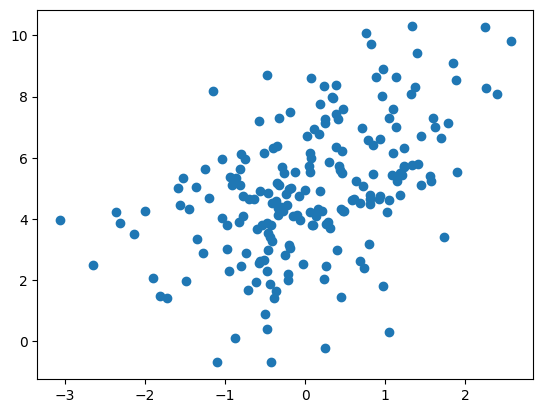

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Nuevamente generamos los datos aleatorios con una desviación estandar conocida
# Alrededor de una funcion lineal conocida y = 1.2x + 0.7
n_samples = 300
ruido_blanco_std = 2
X = np.random.randn(n_samples, 1)
for_bias = np.ones([n_samples, 1])
X_augmented = np.concatenate([for_bias, X], axis=-1)
eps = np.random.randn(n_samples, 1) * ruido_blanco_std
ideal_w = [[5], [1.2]]
target_y = X_augmented @ ideal_w + eps

# Dividir en entrenamiento y validación
n_val_dp = n_samples//3
x_train = X_augmented[:-n_val_dp,:]
y_train = target_y[:-n_val_dp]

x_val = X_augmented[-n_val_dp:,:]
y_val = target_y[-n_val_dp:]

print(x_train.shape, x_val.shape)
# Graficar set de entrenamiento
plt.scatter(x_train[:,-1], y_train)

## Función de costo
Ya que hemos cargado el dataset y sabemos como está compuesto, debemos calcular la función de costo

$ MSE = J(w) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i)^2 $

In [2]:
def mse_loss(y, y_pred):
    """
        Regresa el error cuadrático promedio de todas las predicciones
        y: shape=N Etiquetas
        y_pred: predicciones del modelo
    """
    # TODO: Calcula el resultado de la función de costo
    # ====== Start of solution =====
    loss = 0.5 * ((y - y_pred)**2).mean()
    return loss
    # ====== End of solution =====

# Iniciamos con unos parametros w arbitrarios
w = np.random.uniform(-10, 10, size=(2, 1))

# TODO: Calcula las preddiciones para el conjunto de entrenamiento x_train
y_pred = x_train @ w

# TODO: Calcula la función de costo para las predicciones(y_pred) y los valores reales (y_train)
# ====== Start of solution =====
mse_train = mse_loss(y_train, y_pred)
print(mse_train)
# ====== End of solution =====

30.626570411234265


Podemos visualizar como se ve la función de costo con diferentes pesos.
Si elegimos los pesos que generan el menor costo en el set habremos encontrado los parametros ideales para este problema.

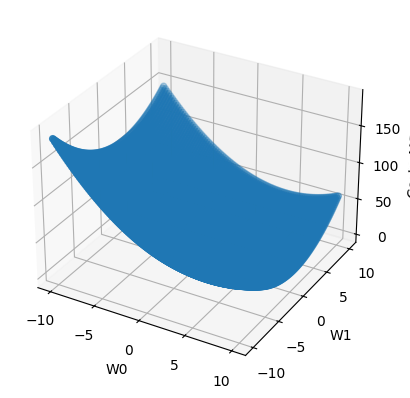

In [3]:
# Probaremos con 100x100 combinaciones de distintos parametros
w0 = np.linspace(-10, 10, 100)
w1 = np.linspace(-10, 10, 100)
w0w0, w1w1 = np.meshgrid(w0, w1)
w0_flat = w0w0.ravel()
w1_flat = w1w1.ravel()
W = np.stack([w0_flat, w1_flat], axis=0)


# Calculamos la función de costo
# TODO: calcula el costo de las predicciones (y_pred) contra etiquetas (y_train)
# usando las 100x100 combindaciones de parametros (W)
# ====== Start of solution =====

y_pred = x_train @ W # todas las predicciones en una matriz 200x10000

calc_cost = np.array([
    # todos los costos en una misma matriz
    mse_loss(y_train, y_pred[:, j:j+1]) 
    for j in range(y_pred.shape[1]) 
])

# ====== End of solution =====

# Graficamos los parametros w con su respectivo costo en el eje de las x
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(w0_flat, w1_flat, calc_cost)

# TODO: Escribe a qué valor corresponde cada eje
# ====== Start of solution =====
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('Costo MSE')
# ====== End of solution =====
plt.show()

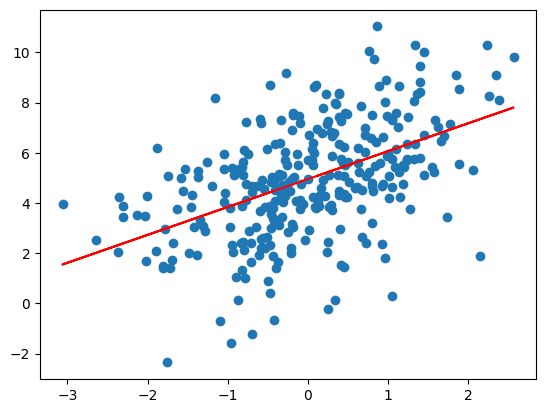

In [4]:
# Podemos encontrar la combinación de pesos que minimizan el costo
# Y de esta manera encontrar los pesos ideales
best_idx = np.argmin(calc_cost)
search_w0 = w0_flat[best_idx]
search_w1 = w1_flat[best_idx]
search_w = [[search_w0], [search_w1]] 

plt.scatter(X, target_y)
# TODO: Grafica la línea de regresión generada por tu modelo search_w
# Encima de las muestras dadas
# ====== Start of solution =====
pred_y = x_train @ search_w
plt.plot(x_train[:,1], pred_y, 'r')
# ====== End of solution =====

En el código anterior evaluamos $100 \times 100$ combinaciones de pesos posibles y encontramos los mejores pesos. En este caso solo tenemos 2 parametros que queremos estimar, por lo que encontrar la solución de esta manera es factible al tener que realizar alrededor de $100^2$ evaluaciones de la función. 

<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de costo tendríamos que hacer si tuviéramos 4 parametros? <br>
    $100^4$
- ¿Qué pasaría si tuviéramos 1 millon de parametros? <br>
    **Demasiado costo computacional, no optimo**

Las redes neuronales tienen millones de parametros para hacer predicciones, por lo que encontrar la solución de esta manera no es factible. Se han encontrado formas más eficientes de encontrar la solución por ejemplo, a través de métodos iterativos. Uno de ellos es decenso de gradiente. Siguiendo la direccion contraria del gradiente del costo con respecto a los pesos, podemos encontrar los parámetros que <b>minimizan</b> la función de costo utilizando menos evaluaciones.

## Descenso de gradiente
En esta sección, optimizarás la función de regresión lineal a través de descenso de gradiente.
La predicción de nuestro modelo está dada con la siguiente funcion:

$ \hat{Y}_i = w_0 + w_1 * x$

$\hat{Y} = \mathbf{X}\mathbf{w}$

<!-- El gradiente de MSE con respecto a $w_0$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_0} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_0}= \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) $

El gradiente de MSE con respecto a $w_1$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_1} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_1} = \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) * x_i $ -->

Donde:
- $\hat{Y}_i \in  \hat{Y}$
- $\mathbf{Y} \in \mathbb{R}^{N}$
- $\mathbf{X} \in  \mathbb{R}^{N \times D}$ en notación aumentada
- $\mathbf{w} \in \mathbb{R}^{D}$ en notación aumentada

Como vimos en clase, el gradiente la función de costo con respecto a los pesos está dado por:

 $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = -\frac{1}{N}X^T\epsilon$

 donde $\epsilon=\mathbf{Y}-\mathbf{X}\mathbf{w}$

 TODO: Completa el código necesario para aplicar descenso de gradiente durante n_iteraciones. Para ello realiza los siguientes pasos:
- Calcula el valor de las predicciones $\mathbf{Y}$
- Calcula el gradiente de la función a optimizar $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Actualiza los pesos con el gradiente $\mathbf{w}^{i+1} = \mathbf{w}^{i} - \alpha \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Repite hasta optener el valor óptimo de $\mathbf{w}$

Es tiempo de programarlo en código

In [5]:
def gradient_descent(X, y, lr, N_iterations, w_start=np.array([0,0])):
    """
    Entradas:
    X: arreglo con los datos en notación aumentada X
    y: vector de etiquetas
    lr: ritmo de aprendizaje
    N_iterations: cantidad de iteraciones de optimización
    w_start: pesos iniciales
        
    Regresa:  
    w_opt: pesos óptimos
    cost_history: arreglo con el valor del costo para cada iteración
    """
    m = X.shape[0]
    cost_history = []
    
    # initialize the coefficients
    w=w_start
    
    for i in range(N_iterations):
        # ====== Start of solution =====
        # TODO: Calcula la predicción 
        hypothesis = X @ w

        # TODO: Calcula el error
        epsilon = y - hypothesis

        # TODO: Calcula el gradiente del MSE loss
        gradient = -(1/m) * (X.T @ epsilon)

        # TODO: Actualiza los pesos
        w = w - lr * gradient
        
        # ====== End of solution =====
        # Calculamos la función de costo y guardamos el resultado
        loss = mse_loss(y, hypothesis)
        cost_history.append(loss)

    print(f"Total de evaluaciones {i}, el costo final fue {loss}")
    w_opt=w
    return w_opt, cost_history

Total de evaluaciones 49, el costo final fue 5.1320192309590515
Total de evaluaciones 59, el costo final fue 2.273990942921233
Total de evaluaciones 79, el costo final fue 1.840127311782653


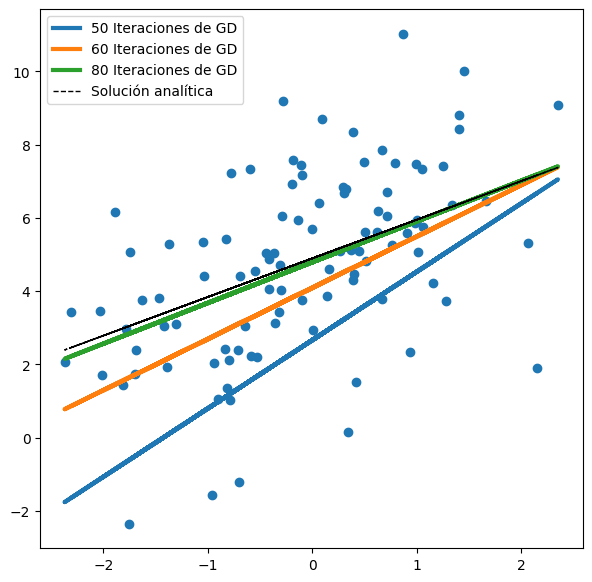

In [6]:
from sklearn import linear_model
# Parámetros de descenso de gradiente
N_iterations = [50,60,80] # 50 60 80

# Pesos iniciales y ritmo de aprendizaje
lr = 0.1 # Utiliza valores cercanos e.g. 0.05, 0.2 .. etc
w_start = np.array([-400,0])
w_start = np.expand_dims(w_start,-1)

# (2.) - (4.) -> Variación de cantidad de iteraciones
plt.figure(figsize=(7,7))
plt.scatter(x_val[:,-1], y_val)
for n_it in N_iterations:
    # Entrenamos el modelo en el set de entrenamiento
    w_opt, ch = gradient_descent(x_train, y_train, lr, n_it, w_start)

    # Visualizamos la predicción en el set de validación
    prediction = x_val @ w_opt
    plt.plot(x_val[:,-1], prediction, label = str(n_it)+" Iteraciones de GD", linewidth=3)

# Obtener la solución analítica
analitic_sol=linear_model.LinearRegression()
analitic_sol.fit(x_train, y_train)

# Visualizar solución analitica
plt.plot(x_val[:,-1], analitic_sol.predict(x_val),label = 'Solución analítica', linewidth=1, linestyle="dashed", color="black")
# plt.ylim(bottom=-10)
plt.legend()
plt.show()

<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de costo se evaluaron para encontrar la solución con un $lr=0.1$? ¿Cómo se compara este número a la solución por busqueda exhaustiva? <br>
    **80 aproximadamente**
- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) a un valor dos veces grande? <br>
   ** llegó en la mitad de iteraciones**
- ¿Qué pasa si cambiamos la tase de aprendizaje a un valor dos veces más chico? <br>
    **tardó el doble en llegar que en el original**
- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) por un valor muy grande? <br>
   **el costo crece exponencialmente**